# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - пошаговый шаблон для выполнения проекта по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

Внимание: вам нужно реализовать весь рабочий код - в ноутбуке предустановлены только парсеры строкового формата. Все остальные ячейки служат как инструкции / места для вашего кода.


#### Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



##### 1. EDA

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).




In [58]:
import json
from collections import Counter
from pathlib import Path
import matplotlib.pyplot as plt
import re

TRAINT_PATH = 'data/train.jsonl'
DEV_PATH = '/data/dev.jsonl'
TEST_PATH = '/data/test.jsonl'

In [59]:
def read_jsonl(path, lines_count = None):
    data = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if lines_count is not None and i >= lines_count:
                break
            line = line.strip()
            if not line:
                continue
            data.append(json.loads(line))
    return data

def parse_entity_type(ent_str):
    parts = ent_str.split("\t")
    type_and_span = parts[1].split()
    return type_and_span[0]

def parse_relation_type(rel_str):
    parts = rel_str.split("\t", 1)
    rest = parts[1].strip()
    return rest.split()[0]

def get_stats(rows, top=15):
    texts_lengths = []
    entities_per_doc = []
    ent_freq = Counter()
    rel_freq = Counter()
    for row in rows:
        texts_lengths.append(len(re.findall(r"\S+", row["text"])))
        entities_per_doc.append(len(row["entities"]))
        for e in row["entities"]:
            ent_freq[parse_entity_type(e)] += 1
        for rel in row["relations"]:
            rel_freq[parse_relation_type(rel)] += 1    
    return {
        "top_entities": ent_freq.most_common(top),
        "top_relations": rel_freq.most_common(top),
        "texts_lengths": texts_lengths,
        "entities_per_doc": entities_per_doc
    }

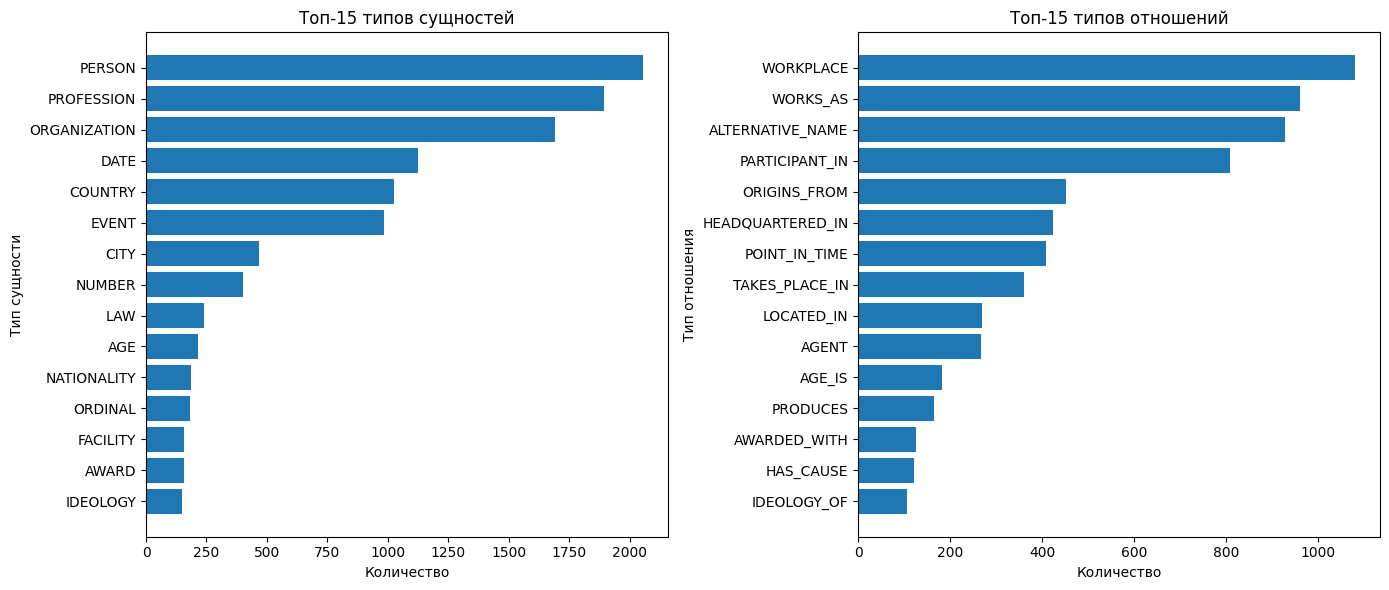

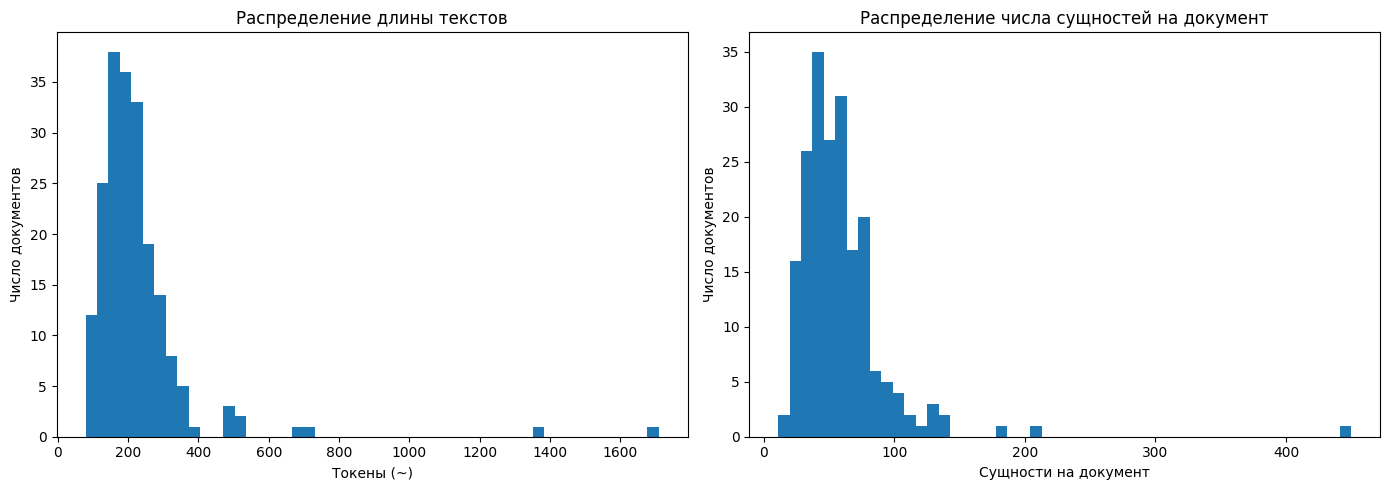

In [60]:
rows = read_jsonl(TRAINT_PATH, 200)
stats = get_stats(rows)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
labels_e = [t for t, _ in stats["top_entities"]][::-1]
values_e = [c for _, c in stats["top_entities"]][::-1]
axes[0].barh(labels_e, values_e)
axes[0].set_title("Топ-15 типов сущностей")
axes[0].set_xlabel("Количество")
axes[0].set_ylabel("Тип сущности")

labels_r = [t for t, _ in stats["top_relations"]][::-1]
values_r = [c for _, c in stats["top_relations"]][::-1]
axes[1].barh(labels_r, values_r)
axes[1].set_title("Топ-15 типов отношений")
axes[1].set_xlabel("Количество")
axes[1].set_ylabel("Тип отношения")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(stats["texts_lengths"], bins=50)
axes[0].set_title("Распределение длины текстов")
axes[0].set_xlabel("Токены (~)")
axes[0].set_ylabel("Число документов")

axes[1].hist(stats["entities_per_doc"], bins=50)
axes[1].set_title("Распределение числа сущностей на документ")
axes[1].set_xlabel("Сущности на документ")
axes[1].set_ylabel("Число документов")

plt.tight_layout()
plt.show()


По выборке и 200 строк и построенным графикам можно сделать следующие выводы:
1) По частотам сущностей и отношений видно, что присутствует дисбаланс классов. При моделировании можно ожидать, что редкие типы будут хуже по F1.
2) Большинство текстов относительно короткие, но есть очень длинные. Это значит, что часть текстов может обрезаться, нужно будет это учитывать
3) По количеству сущностей видно, что в некоторых документах очень большое число сущностей, что может создавать сложные примеры для NER

##### Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [ ]:

import re
from collections import Counter

# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}



##### 3. Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.



##### 4. Модель: `JointModel` + custom loss (uncertainty weighting)


##### 5. Training / Validation



##### 6. Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?


##### Заключение

Этот шаблон даёт вам чёткую дорожную карту и рабочие точки, где нужно реализовать код. В ноутбуке предоставлены только парсеры строкового формата - всё остальное вы пишете самостоятельно: токенизация/выравнивание меток, датасеты, модель, loss, тренировка и анализ.

Удачи - приступайте к реализации прямо в ноутбуке!